# Continuous Control

The environment for this project is [Reacher](https://github.com/udacity/deep-reinforcement-learning/tree/master/p2_continuous_control) from Unity, and it's provided in the `setup` folder. We'll implement the A2C algorithm as the synchronous version of [A3C](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (but the input won't be directly from pixels). Results will be shown in this notebook and the best solution will be implemented in `main.py`.

![final](imgs/gif.gif "final")

> The model used to generate this gif is `final.pth` (Dueling Double DQN), which was trained for 700 episodes using `main.py`.

## 1. Prepare dependencies and environment

Take a look at README.md before executing this notebook and make sure that the kernel is set to **p2_continuous_control**.

In [1]:
!pip -q install ./setup

import sys
import platform

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
from torch import nn

from setup import unityagents
from unityagents import UnityEnvironment

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Unity environments contain **brains**, our interfaces for controlling agents. We'll be conrtolling the first (default) brain in the environment. It's also useful to keep information such as `state_size`, `action_size` and `num_agents`.

In [2]:
env = None
system = platform.system()
if system == 'Linux':
    env = UnityEnvironment(file_name="setup/Reacher_Linux/Reacher.x86_64")
elif system == 'Darwin':
    env = UnityEnvironment(file_name="setup/Reacher.app")
elif system == 'Windows':
    env = UnityEnvironment(file_name="setup/Reacher_Windows_x86_64/Reacher.exe")
else:
    print('Cannot find environment for this system.')

# use the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Actor

In [5]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers=[64, 128, 64]):
        super(Actor, self).__init__()
        self.action_size = action_size

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the actor will output the parameters of a normal distribution,
        self.mu_layer = nn.Linear(hidden_layers[-1], action_size)
        self.sigma = nn.Parameter(torch.ones(1, action_size))

    def forward(self, state):
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        mu = self.mu_layer(state)
        return mu, self.sigma

## 3. Critic

In [6]:
class Critic(nn.Module):

    def __init__(self, state_size, hidden_layers=[64, 128, 64]):
        super(Critic, self).__init__()

        # prepare the first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])

        # prepare the rest of the hidden layers
        A = hidden_layers[:-1]
        B = hidden_layers[1:]
        self.hidden_layers.extend([nn.Linear(a, b) for a, b in zip(A, B)])

        # the critic outputs only a scalar V(s)
        self.value_layer = nn.Linear(hidden_layers[-1], 1)

    def forward(self, state):
        # connect layers to each other and put relu activations between them
        for layer in self.hidden_layers:
            state = layer(state)
            state = F.relu(state)
        value = self.value_layer(state)
        return value

## 4. Advantage estimation

### 4.1 $n$-step

In [ ]:
def n_step():
    pass

### 4.2 GAE

In [ ]:
def gae():
    pass

## 5. Agent

In [7]:
class A2CAgent:
    
    # -- initialization -- #

    def __init__(self, state_size, action_size, n=4, 
                 alpha=0.0001, gamma=0.95, beta=0.01, tau=0.25):
        
        self.alpha, self.gamma, self.beta, self.tau = alpha, gamma, beta, tau
        self.n = n        
        self.reset()

    def reset_temporary_buffer(self):
        self.tmp_r, self.tmp_ns, self.tmp_d = [], [], []
        self.tmp_log_prob, self.tmp_critic_out = [], []

    def reset(self):        
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.alpha)
        
        self.critic = Critic(state_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)

        self.reset_temporary_buffer()
        self.i = 0

    # -- initialization -- #
    
    def act(self, state):
        state = torch.FloatTensor(state).to(device)
        
        mu, sigma = self.actor(state)
        value = self.critic(state)

        dist = torch.distributions.Normal(mu, sigma)
        # note clamp happens later
        action = dist.sample().detach()
        log_prob = dist.log_prob(action)

        self.tmp_log_prob.append(log_prob.unsqueeze(0))
        self.tmp_critic_out.append(value.unsqueeze(0))
        
        return np.clip(np.array(action), -1, 1)
    
    def store(self, s, a, r, ns, d):
        # ignore s and a because they're already handled in act(state)
        self.tmp_r.append(torch.FloatTensor(r).unsqueeze(1).to(device))
        self.tmp_ns.append(torch.FloatTensor(ns).to(device))
        self.tmp_d.append(torch.FloatTensor(d).unsqueeze(1).to(device))
        
        if self.i == self.n - 1:
            self.learn()

        self.i = (self.i + 1) % self.n

    def learn(self):

        log_prob = torch.cat(self.tmp_log_prob, dim=0)
        critic_out = torch.cat(self.tmp_critic_out, dim=0)

        future = self.critic(self.tmp_ns[-1])
        tmp_returns = []
        for reward, done in zip(reversed(self.tmp_r), reversed(self.tmp_d)):
            future = reward + self.gamma * (1 - done) * future
            tmp_returns.append(future.unsqueeze(0))
        returns = torch.cat(tmp_returns, dim=0).to(device)
        
        # calc advantages
        advantages = returns - critic_out

        policy_loss = -log_prob * advantages.detach()
        value_loss = 0.5 * (returns.detach() - critic_out) ** 2
        
        self.actor_optimizer.zero_grad()
        policy_loss.mean().backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 5)
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        value_loss.mean().backward()
        nn.utils.clip_grad_norm_(self.critic.parameters(), 5)
        self.critic_optimizer.step()

        self.reset_temporary_buffer()

## 6. Training an agent

In [ ]:
agents = [('A2Cn4', A2CAgent(state_size, action_size, n=5))]

In [3]:
def execute_episode(agent, env):
    # prepare the environment
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    
    # get the initial state
    states = env_info.vector_observations
    while True:

        # evaluate the current state
        actions = agent.act(states)

        # execute the chosen action and get the outcome
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done

        # store the experience (also automatically learn, from time to time)
        agent.store(states, actions, rewards, next_states, dones)

        # prepare for the next iteration
        states = next_states
        scores += rewards

        if np.any(dones):
            break
    
    # return the total rewards obtained
    return np.mean(scores)

In [4]:
def train(agent, env, episodes=200, repeat=1, consecutive_episodes=100, show_output=True, save_as=None):

    results = [None] * repeat
    for r in range(repeat):
        partial_results = [None] * episodes

        # reset the agent to start learning from scratch
        agent.reset()
        for i in range(episodes):

            # execute all the episodes and store the results
            score = execute_episode(agent, env)
            partial_results[i] = score
            
            if show_output:
                print("\r[{}] Episode: {}, Score: {}".format(r+1, i+1, score), end="")
                sys.stdout.flush()
        if show_output:
            print()

        results[r] = partial_results

        # store the trained model if requested
        if save_as is not None:
            torch.save(agent.actor.state_dict(), '{}/{}_actor.pth'.format(save_as, r+1))
            torch.save(agent.critic.state_dict(), '{}/{}_critic.pth'.format(save_as, r+1))

    # use convolutions to calculate the mean and standard deviation summarizing the training step
    results = np.array(results)
    mean = signal.convolve2d(results, np.ones([repeat, consecutive_episodes]) / (repeat * consecutive_episodes), mode='valid')    
    v = signal.convolve2d(results, np.ones([1, consecutive_episodes]) / consecutive_episodes, mode='valid')
    std_dev = signal.convolve2d(v ** 2 - mean ** 2, np.ones([repeat, 1]) / repeat, mode='valid') ** (1/2)
    return mean.flatten(), std_dev.flatten(), results

In [10]:
training_results = []
for ag in agents:
    name, agent = ag
    print('Agent: {}'.format(name))
    mean, std_dev, full_report = train(agent, env, save_as='models/{}'.format(name.replace(" ", "_")))
    training_results.append((mean, std_dev, full_report))
# env.close()

Agent: A2Cn4
[1] Episode: 200, Score: 39.14749912498519


## 7. Comparing the results

A2Cn4: Solved after 100 episodes


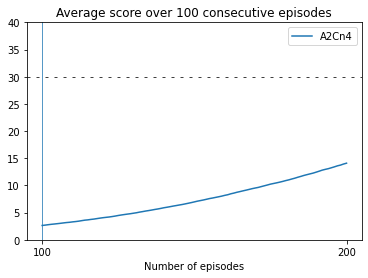

In [16]:
def plot_results(agents, training_results):
    for agent, ts in zip(agents, training_results):
        mean, std_dev, _ = ts
        episode_solved = np.argmax(mean > 30) + 100
        print('{}: Solved after {} episodes'.format(agent[0], episode_solved))

        x = np.arange(100, 100 + mean.size)
        line = plt.plot(x, mean, label = agent[0])
        plt.fill_between(x, mean + std_dev, mean - std_dev, alpha=0.25)
        plt.axvline(episode_solved, lw=0.75, color=line[0].get_color())

    plt.axhline(30, dashes=(4, 8), lw=0.75, color='black')
    plt.xticks(np.arange(1, 1 + mean.size / 100) * 100)
    plt.yticks(np.arange(0, 9) * 5)
    plt.xlabel('Number of episodes')
    plt.title('Average score over 100 consecutive episodes')
    plt.legend()
    plt.show()

plot_results(agents[:1], training_results[:1])
# plot_results(agents[2:], training_results[2:])

## 8. Possible improvements

## 9. Conclusions